In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime

# 读取 NetCDF 文件
nc_file = "004_2006_2080_352_360.nc"
ds = xr.open_dataset(nc_file)

# 读取 Excel 文件
ghg_file = "finalquarterlyghgemissions.xlsx"
df_ghg = pd.read_excel(ghg_file, sheet_name="Table 1", skiprows=3)  # 跳过前三行，使 "Time Period" 成为列名

# 解析 Excel 时间列
# 转换格式，例如 "1999 Q1" -> (1999, 1)，以便匹配 NetCDF 数据
df_ghg["Year"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[0]))
df_ghg["Quarter"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[1][1]))

# 计算 NetCDF 时间变量对应的年份和季度
# 转换 cftime.DatetimeNoLeap 为 numpy datetime64
time_values = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in ds["time"].values])

years = time_values.astype("datetime64[Y]").astype(int) + 1970  # 转换为年份
months = time_values.astype("datetime64[M]").astype(int) % 12 + 1  # 转换为月份
quarters = ((months - 1) // 3 + 1)  # 计算季度

# 创建时间匹配的 DataFrame
df_nc_time = pd.DataFrame({"Year": years, "Quarter": quarters, "time_index": np.arange(len(time_values))})

# 合并 GHG 数据到时间匹配表
df_merged = df_nc_time.merge(df_ghg, on=["Year", "Quarter"], how="left")

# 将 GHG 数据添加到 NetCDF 数据集
ghg_values = df_merged["Seasonally adjusted emissions"].values
ds["GHG_Emissions"] = ("time",), ghg_values

# 保存合并后的 NetCDF 文件
output_nc_file = "merged_ghg_data.nc"
ds.to_netcdf(output_nc_file)
print(f"合并完成，文件已保存为 {output_nc_file}")


合并完成，文件已保存为 merged_ghg_data.nc


In [5]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. 加载合并后的数据集
file_path = 'merged_ghg_data.nc'
ds = xr.open_dataset(file_path)

# 2. 提取 TREFMXAV_U 数据
# 注意：Manchester 的经度 -2.2426 转换为 0-360 格式，即 360 - 2.2426 = 357.7574
manchester_lat = 53.4808
manchester_lon = 360 - 2.2426  # 357.7574
manchester_data = ds['TREFMXAV_U'].sel(lat=manchester_lat, lon=manchester_lon, method="nearest")

# 3. 转换数据为 pandas DataFrame，并确保 time 为 datetime 格式
df = manchester_data.to_dataframe().reset_index()

# 打印 time 列中第一个元素的类型（验证是否为 datetime 格式）
print("原始 time 数据类型：", type(df['time'].iloc[0]))

# 如果 time 为 cftime.DatetimeNoLeap，则转换为 pd.Timestamp
df['time'] = df['time'].apply(lambda x: pd.Timestamp(x.strftime("%Y-%m-%d")) 
                              if isinstance(x, cftime.DatetimeNoLeap) else x)
df = df.sort_values('time')

# 4. 划分训练集和测试集
# 训练集：2006-01-01 到 2049-12-31；测试集：2050-01-01 到 2080-12-31
train_df = df[(df['time'] >= '2006-01-01') & (df['time'] < '2050-01-01')]
test_df = df[(df['time'] >= '2050-01-01') & (df['time'] <= '2080-12-31')]

# 5. 提取目标变量 TREFMXAV_U，并重塑形状
train_values = train_df['TREFMXAV_U'].values.reshape(-1, 1)
test_values = test_df['TREFMXAV_U'].values.reshape(-1, 1)

# 6. 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# 7. 构造时间序列数据（例如，使用过去 3 个时间步预测下一个时间步）
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 3
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# 8. 构建 LSTM 模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 显示模型摘要
model.summary()

# 9. 训练模型（你可以根据需要调整 epochs 和 batch_size）
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# 10. 使用模型进行预测
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

print("预测结果示例：", predictions[:5])


原始 time 数据类型： <class 'cftime._cftime.DatetimeNoLeap'>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
502/502 [==============================] - 7s 9ms/step - loss: 0.0224 - val_loss: 0.0053
Epoch 2/50
502/502 [==============================] - 3s 6ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 3/50
502/502 [==============================] - 3s 7ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 4/50
502/502 [==============================] - 3s 7ms/step - loss: 0.0037 - val_loss: 0

In [7]:
import pandas as pd
from prophet import Prophet
import logging

# Suppress verbose logs
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

def process_table(table_name):
    """Process and forecast seasonal emissions for a single table."""
    try:
        # Read data (skip first 3 rows)
        df = pd.read_excel(
            ghg_file,
            sheet_name=table_name,
            skiprows=3,
            usecols="A:C"  # Columns: Time Period, NSA Emissions, SA Emissions
        )
        df.columns = ["Time Period", "NSA_Emissions", "SA_Emissions"]

        # Convert time period to datetime
        df["ds"] = df["Time Period"].apply(
            lambda x: pd.to_datetime(
                x.replace(" Q1", "-03-31")
                .replace(" Q2", "-06-30")
                .replace(" Q3", "-09-30")
                .replace(" Q4", "-12-31")
            )
        )
        
        # Use Seasonal Adjusted data as target
        df["y"] = df["SA_Emissions"]

        # Train model
        model = Prophet(
            yearly_seasonality=True,
            seasonality_mode="multiplicative",
            changepoint_prior_scale=0.3
        )
        model.fit(df[["ds", "y"]])

        # Generate future dates (2024Q4–2080Q4)
        future = model.make_future_dataframe(
            periods=56*4,  # 56 years × 4 quarters
            freq="Q",
            include_history=False
        )

        # Predict
        forecast = model.predict(future)

        # Format predictions
        forecast["Time Period"] = forecast["ds"].dt.year.astype(str) + " Q" + forecast["ds"].dt.quarter.astype(str)
        
        # Merge data
        merged = pd.merge(
            df[["Time Period", "SA_Emissions"]],
            forecast[["Time Period", "yhat"]],
            on="Time Period",
            how="outer"
        )
        
        # Overwrite future SA_Emissions with predictions
        merged["SA_Emissions"] = merged["SA_Emissions"].fillna(merged["yhat"])
        
        # For Table 1: Keep only the seasonal column
        if table_name == "Table 1":
            output = merged[["Time Period", "SA_Emissions"]]
        else:
            output = merged  # Keep all columns for other tables

        # Save results
        output.to_excel(f"{table_name}_forecast.xlsx", index=False)
        print(f"Processed {table_name} successfully")

    except Exception as e:
        print(f"Error processing {table_name}: {str(e)}")

if __name__ == "__main__":
    ghg_file = "finalquarterlyghgemissions.xlsx"
    tables = [f"Table {i}" for i in range(1, 7)]  # Tables 1-6

    for table in tables:
        process_table(table)

    print("Processing completed. Key features:")
    print("- Only Seasonal column retained for Table 1")
    print("- Future predictions merged into Seasonal column")
    print("- Separate forecasts generated for all tables")

C:\Users\Alienware\anaconda3\envs\EART\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


Processed Table 1 successfully


C:\Users\Alienware\anaconda3\envs\EART\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


Processed Table 2 successfully


C:\Users\Alienware\anaconda3\envs\EART\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


Processed Table 3 successfully


C:\Users\Alienware\anaconda3\envs\EART\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


Processed Table 4 successfully


C:\Users\Alienware\anaconda3\envs\EART\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


Processed Table 5 successfully
Processed Table 6 successfully
Processing completed. Key features:
- Only Seasonal column retained for Table 1
- Future predictions merged into Seasonal column
- Separate forecasts generated for all tables


C:\Users\Alienware\anaconda3\envs\EART\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


In [18]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime

# Read NetCDF file
nc_file = "003_2006_2080_352_360.nc"
ds = xr.open_dataset(nc_file)

# Read forecasted Excel file (Table1_forecast.xlsx)
ghg_file = "Table 1_forecast.xlsx"  # Modified filename
df_ghg = pd.read_excel(ghg_file, sheet_name=0, skiprows=0)  # Read first worksheet (no header skip)

# Parse Excel time column (format example: "1999 Q1")
df_ghg["Year"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[0]))
df_ghg["Quarter"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[1][1]))

# Calculate corresponding year and quarter for NetCDF time variable
# Convert cftime.DatetimeNoLeap to numpy datetime64
time_values = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in ds["time"].values])

years = time_values.astype("datetime64[Y]").astype(int) + 1970  # Convert to year
months = time_values.astype("datetime64[M]").astype(int) % 12 + 1  # Convert to month
quarters = ((months - 1) // 3 + 1)  # Calculate quarter

# Create time-matching DataFrame
df_nc_time = pd.DataFrame({"Year": years, "Quarter": quarters, "time_index": np.arange(len(time_values))})

# Merge GHG data to time mapping table (using SA_Emissions column)
df_merged = df_nc_time.merge(
    df_ghg[["Year", "Quarter", "SA_Emissions"]],  # Keep only essential columns
    on=["Year", "Quarter"],
    how="left"
)

# Handle potential missing values (if forecast data doesn't fully cover NetCDF time range)
if df_merged["SA_Emissions"].isnull().any():
    print("Warning: Missing forecast values for some time points, using linear interpolation")
    df_merged["SA_Emissions"] = df_merged["SA_Emissions"].interpolate(method="linear")

# Add SA_Emissions data to NetCDF dataset
ds["SA_Emissions"] = ("time", df_merged["SA_Emissions"].astype(np.float32).values) 

# 然后设置属性
ds["SA_Emissions"].attrs = {
    "units": "thousand tonnes CO2 equivalent",
    "long_name": "Seasonally Adjusted Greenhouse Gas Emissions"
}

# Save merged NetCDF file
output_nc_file = "merged_ghg_data_with_SA_003.nc"
ds.to_netcdf(output_nc_file)
print(f"Merging complete. File saved as {output_nc_file}")

PermissionError: [Errno 13] Permission denied: b'C:\\Users\\Alienware\\Desktop\\UOM\\EART60702\\project2\\merged_ghg_data_with_SA_003.nc'

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
from prophet import Prophet

# Read NetCDF file
nc_file = "003_2006_2080_352_360.nc"
ds = xr.open_dataset(nc_file)

# Read forecasted Excel file (Table1_forecast.xlsx)
ghg_file = "Table 1_forecast.xlsx"
df_ghg = pd.read_excel(ghg_file, sheet_name=0, skiprows=0)

# Parse Excel time column
df_ghg["Year"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[0]))
df_ghg["Quarter"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[1][1]))

# Convert NetCDF time
time_values = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in ds["time"].values])
years = time_values.astype("datetime64[Y]").astype(int) + 1970
months = time_values.astype("datetime64[M]").astype(int) % 12 + 1
quarters = ((months - 1) // 3 + 1)

# Create time-matching DataFrame
df_nc_time = pd.DataFrame({
    "Year": years.astype(int),  # Ensure integer type
    "Quarter": quarters.astype(int),  # Ensure integer type
    "time_index": np.arange(len(time_values))
})

# Merge data
df_merged = df_nc_time.merge(
    df_ghg[["Year", "Quarter", "SA_Emissions"]],
    on=["Year", "Quarter"],
    how="left"
)

# Ensure merged Year/Quarter are integers
df_merged["Year"] = df_merged["Year"].astype(int)
df_merged["Quarter"] = df_merged["Quarter"].astype(int)

# Handle missing values with Prophet
if df_merged["SA_Emissions"].isnull().any():
    print("Using Prophet for missing value imputation...")
    
    # Create dates with explicit type conversion
    def create_date(row):
        year = int(row["Year"])  # Force integer conversion
        quarter = int(row["Quarter"])  # Force integer conversion
        return pd.Timestamp(
            year=year,
            month=3*(quarter-1)+1,  # Convert quarter to month
            day=1
        )
    
    df_merged["ds"] = df_merged.apply(create_date, axis=1)
    
    # Prepare training data
    train_df = df_merged[~df_merged["SA_Emissions"].isnull()]
    train_df = train_df[["ds", "SA_Emissions"]].rename(columns={"SA_Emissions": "y"})
    
    if len(train_df) < 2:
        raise ValueError("Prophet requires at least 2 data points for forecasting")
    
    # Configure Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    model.add_seasonality(name="quarterly", period=91.25, fourier_order=5)
    model.fit(train_df)
    
    # Generate predictions
    future = model.make_future_dataframe(
        periods=len(df_merged) - len(train_df),
        freq="QS"  # Quarterly frequency
    )
    forecast = model.predict(future)
    
    # Merge forecast results
    df_merged = df_merged.merge(
        forecast[["ds", "yhat"]],
        on="ds",
        how="left"
    )
    df_merged["SA_Emissions"] = df_merged["SA_Emissions"].fillna(df_merged["yhat"])
    df_merged.drop(["ds", "yhat"], axis=1, inplace=True)

# Final validation
if df_merged["SA_Emissions"].isnull().any():
    raise ValueError("Unhandled missing values exist")

# Add variable to NetCDF
ds["SA_Emissions"] = ("time", df_merged["SA_Emissions"].astype(np.float32).values)
ds["SA_Emissions"].attrs = {
    "units": "thousand tonnes CO2 equivalent",
    "long_name": "Seasonally Adjusted Greenhouse Gas Emissions"
}

# Save results
output_nc_file = "merged_ghg_data_with_SA_003.nc"
ds.to_netcdf(output_nc_file)
print(f"Processing completed. Results saved to {output_nc_file}")

C:\Users\Alienware\anaconda3\envs\EART\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Using Prophet for missing value imputation...


04:40:58 - cmdstanpy - INFO - Chain [1] start processing
04:41:54 - cmdstanpy - INFO - Chain [1] done processing


Processing completed. Results saved to merged_ghg_data_with_SA_003.nc


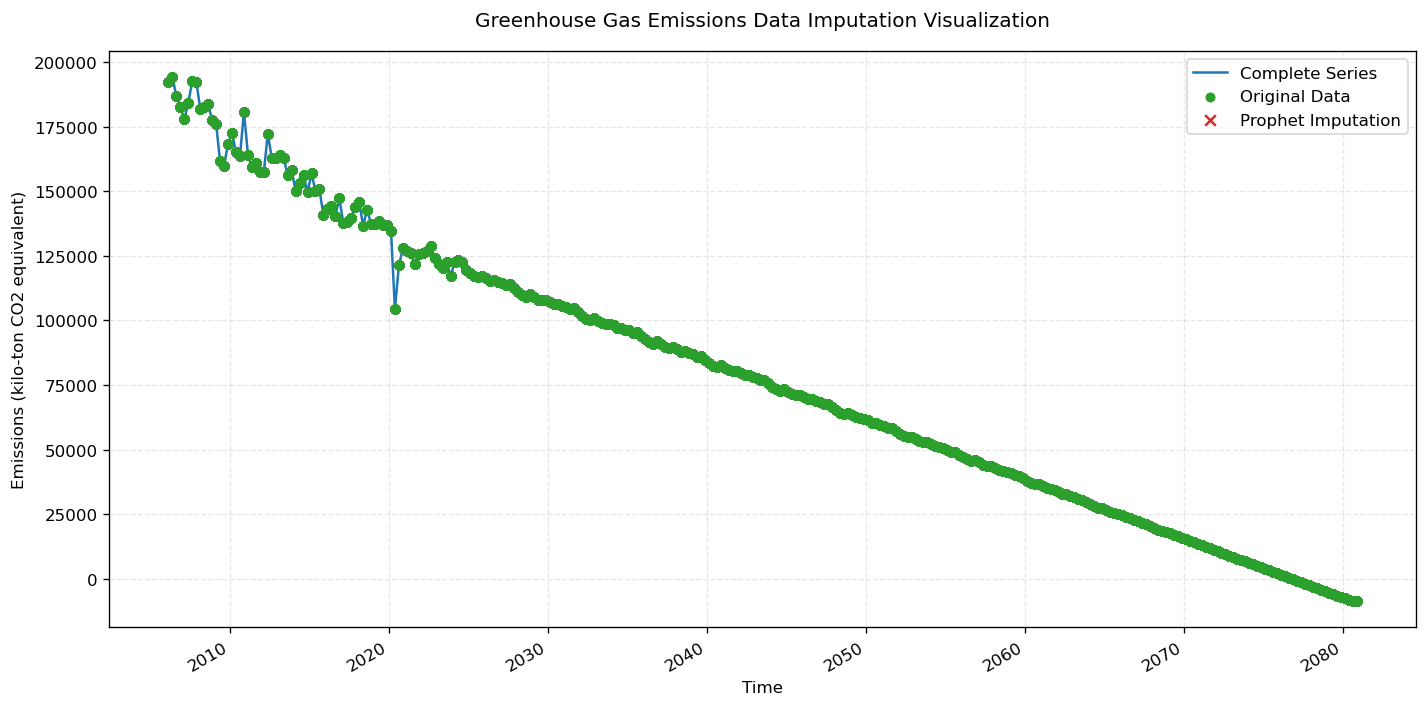

In [2]:
# Corrected timestamp generation code
timestamps = df_merged.apply(
    lambda row: pd.Timestamp(
        year=int(row['Year']),
        month=3 * int(row['Quarter']) -1,  # Corrected quarter-to-month conversion
        day=15
    ), 
    axis=1
)

# Complete visualization code (revised version)
import matplotlib.pyplot as plt

# Generate correct time labels (mid-quarter months: Feb, May, Aug, Nov)
timestamps = df_merged.apply(
    lambda row: pd.Timestamp(
        year=int(row['Year']),
        month=3 * int(row['Quarter']) - 1,  # Q1->Feb(3*1-1=2), Q2->May(3*2-1=5)
        day=15
    ),
    axis=1
)

# Create visualization DataFrame
viz_df = pd.DataFrame({
    'Time': timestamps,
    'Original': df_merged['SA_Emissions'],
    'Imputed_Mask': df_merged['SA_Emissions'].isnull()  # Flag imputation points
})

# Configure plot style
plt.figure(figsize=(12, 6), dpi=120)
plt.rcParams['font.size'] = 10

# Plot main series
main_plot = plt.plot(
    viz_df['Time'], 
    viz_df['Original'],
    color='#1f77b4',
    linewidth=1.5,
    label='Complete Series',
    zorder=1
)

# Mark original data points
original_points = plt.scatter(
    viz_df.loc[~viz_df['Imputed_Mask'], 'Time'],
    viz_df.loc[~viz_df['Imputed_Mask'], 'Original'],
    color='#2ca02c',
    s=25,
    label='Original Data',
    zorder=2
)

# Mark imputed data points
imputed_points = plt.scatter(
    viz_df.loc[viz_df['Imputed_Mask'], 'Time'],
    viz_df.loc[viz_df['Imputed_Mask'], 'Original'],
    color='#d62728',
    marker='x',
    s=40,
    linewidth=1.5,
    label='Prophet Imputation',
    zorder=3
)

# Add annotations and labels
plt.title('Greenhouse Gas Emissions Data Imputation Visualization', pad=15)
plt.xlabel('Time')
plt.ylabel('Emissions (kilo-ton CO2 equivalent)')
plt.grid(alpha=0.3, linestyle='--')
plt.legend()

# Auto-format time axis
plt.gcf().autofmt_xdate()

# Save and display
plt.tight_layout()
plt.savefig('prophet_filling_visualization.png', bbox_inches='tight')
plt.show()

In [10]:
ds

<xarray.Dataset>
Dimensions:       (time: 27374, lat: 11, lon: 6)
Coordinates:
  * lat           (lat) float32 49.48 50.42 51.36 52.3 ... 57.02 57.96 58.9
  * lon           (lon) float32 352.5 353.8 355.0 356.2 357.5 358.8
  * time          (time) object 2006-01-02 00:00:00 ... 2080-12-31 00:00:00
Data variables:
    TREFMXAV_U    (time, lat, lon) float32 ...
    FLNS          (time, lat, lon) float32 ...
    FSNS          (time, lat, lon) float32 ...
    PRECT         (time, lat, lon) float32 ...
    PRSN          (time, lat, lon) float32 ...
    QBOT          (time, lat, lon) float32 ...
    TREFHT        (time, lat, lon) float32 ...
    UBOT          (time, lat, lon) float32 ...
    VBOT          (time, lat, lon) float32 ...
    SA_Emissions  (time) float32 1.922e+05 1.922e+05 ... -8.675e+03 -8.675e+03